In [0]:
from unittest import mock
import os
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from tensorflow.python.estimator import estimator
from tensorflow.python.training.basic_session_run_hooks import CheckpointSaverHook, meta_graph
from tensorflow.python.platform import tf_logging as logging
from google.colab import drive, auth

In [0]:
#################################### SETUP #####################################

def setup():
    drive.mount('/content/gdrive')
    auth.authenticate_user()


def upload_credentials():
    # Upload credentials to TPU.
    with tf.Session(TF_MASTER) as sess:    
        with open('/content/adc.json', 'r') as f:
            auth_info = json.load(f)
        tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)

In [0]:
################################# DATA INPUT ###################################

def parser(serialized_example):
        """Parses a single example into image and label tensors."""
        features = tf.parse_single_example(
            serialized_example,
            features={
                'image_raw': tf.FixedLenFeature([], tf.string),
                'label': tf.FixedLenFeature([], tf.int64)   # label is unused
            })

        image = tf.decode_raw(features['image_raw'], tf.uint8)
        image.set_shape([48 * 48 * 4])
        image = tf.reshape(image, [48, 48, 4])[:,:,:CHANNELS]
        # Normalize the values of the image from [0, 255] to [-1.0, 1.0]
        image = tf.cast(image, dtype=tf.float32) / 127.5 - 1

        return image


def make_input_fn(is_training=True):
    def input_fn(params):
        batch_size = params['batch_size']
        dataset = tf.data.TFRecordDataset(data_file).map(parser).cache().shuffle(batch_size)
        if is_training:
            dataset = dataset.repeat()
        images = dataset.prefetch(batch_size).batch(batch_size, drop_remainder=True).make_one_shot_iterator().get_next()

        if ADD_NOISE_TO_EXAMPLE:
            images += tf.random_normal(shape=tf.shape(images), mean=0.0, stddev=0.1, dtype=tf.float32)

        features = {
            'real_images': images,
            'random_noise': tf.random_uniform([params['batch_size'], LATENT_DIM], -1, 1, dtype=tf.float32)
        }
        return features, None
    return input_fn


def noise_input_fn(params):  
    noise_dataset = tf.data.Dataset.from_tensors(tf.constant(np.random.uniform(-1, 1, (params['batch_size'], LATENT_DIM)), dtype=tf.float32))
    return {'random_noise': noise_dataset.make_one_shot_iterator().get_next()}, None


In [0]:
############################### DATA SAVEING ###################################
 
def images_to_zero_one(images):
        return np.clip(np.array(images) * 0.5 + 0.5, 0., 1.)


def save_imgs(epoch, images):
    if not os.path.exists(GOOGLE_DRIVE_DIR):
        os.mkdir(GOOGLE_DRIVE_DIR)

    # Rescale images to 0 - 1
    images = images_to_zero_one(images)
    fig, axs = plt.subplots(R, C)

    for i in range(R):
        for j in range(C):
            axs[i,j].imshow(images[C*i + j])
            axs[i,j].axis('off')

    fig.savefig(os.path.join(GOOGLE_DRIVE_DIR, '{}.png'.format(epoch)))
    plt.close()

In [0]:
################################## MODEL #######################################

def _leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=ALPHA)


def _relu(x):
    return tf.nn.relu(x)


def _batch_norm(x, is_training, name):
    return tf.layers.batch_normalization(x, momentum=0.8, epsilon=1e-5, 
                                         training=is_training, name=name)


def _dense(x, neurons, name, activation=None):
    return tf.layers.dense(x, neurons, name=name, activation=activation,
                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))


def _conv2d(x, filters, stride, name, activation=None):
    return tf.layers.conv2d(x, filters, [KERNEL_SIZE, KERNEL_SIZE], 
                            strides=[stride, stride], activation=activation,
                            padding='same', name=name,
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))


def _deconv2d(x, filters, stride, name, activation=None):
    return tf.layers.conv2d_transpose(x, filters, [KERNEL_SIZE, KERNEL_SIZE],
                                      strides=[stride, stride], activation=activation,
                                      padding='same', name=name,
                                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))


def _dropout(x, name):
    return tf.nn.dropout(x, rate=DROPOUT_PROB, name=name)


def convolution_block(x, filters, resize_factor, is_training, index,
                      activation=_leaky_relu, dropout=False, batch_norm=True):

    x = _conv2d(x, filters=filters, stride=resize_factor, activation=activation, name='conv_{}'.format(index))
    if batch_norm:
        x = _batch_norm(x, is_training, name='bn_conv_{}'.format(index))
    if dropout:
        x = _dropout(x, name='drop_deconv_{}'.format(index))
    return x


def deconvolution_block(x, filters, resize_factor, is_training, index,
                        activation=_relu, dropout=False, batch_norm=True):

    x = _deconv2d(x, filters=filters, stride=resize_factor, activation=activation, name='conv_{}'.format(index))
    if batch_norm:
        x = _batch_norm(x, is_training, name='bn_deconv_{}'.format(index))
    if dropout:
        x = _dropout(x, name='drop_deconv_{}'.format(index))
    return x


class Dcgan:

    @staticmethod
    def discriminator(x, is_training=True, scope='Discriminator'):
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
            x = convolution_block(x, 64, 2, is_training, 11, batch_norm=False)
            x = convolution_block(x, 128, 2, is_training, 12)
            x = convolution_block(x, 256, 2, is_training, 13)
            x = convolution_block(x, 512, 2, is_training, 14)
#             x = convolution_block(x, 512, 1, is_training, 15)

            x = tf.layers.Flatten()(x)
            x = _dense(x, neurons=1, name='d_dense')

            return x

    @staticmethod
    def generator(x, is_training=True, scope='Generator'):
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
            x = _dense(x, 1024 * 3 * 3, activation=tf.nn.relu, name='g_dense')
            x = tf.reshape(x, [-1, 3, 3, 1024])

            x = deconvolution_block(x, 512, 2, is_training, 21)
            x = deconvolution_block(x, 256, 2, is_training, 22)
            x = deconvolution_block(x, 128, 2, is_training, 23)
#             x = deconvolution_block(x, 64, 2, is_training, 24)
            x = deconvolution_block(x, CHANNELS, 2, is_training, 25, activation=tf.tanh, batch_norm=False)

            return x

In [0]:
################################### FID ########################################

# Not working currently

#FID    
def calculate_fid(images_1, images_2):
    import sys
    import functools
    import time
    from tensorflow.python.ops import array_ops
    from tensorflow.python.ops import functional_ops
    tfgan = tf.contrib.gan

    # A smaller BATCH_SIZE reduces GPU memory usage, but at the cost of a slight slowdown
    BATCH_SIZE = 1024

    def inception_activations(images, num_splits=1):
        print(images.shape)
        sliced_images = images[:,0:48,0:48,:3]
        size = 299
        resized_images = tf.image.resize_bilinear(sliced_images, [size, size])
        generated_images_list = array_ops.split(resized_images, num_or_size_splits = num_splits)
        activations = functional_ops.map_fn(
            fn = functools.partial(tfgan.eval.run_inception, output_tensor = 'pool_3:0'),
            elems = array_ops.stack(generated_images_list),
            parallel_iterations = 1,
            back_prop = False,
            swap_memory = True,
            name = 'RunClassifier')
        activations = array_ops.concat(array_ops.unstack(activations), 0)
        return activations

    act1 = inception_activations(images_1)
    act2 = inception_activations(images_2)
    return tfgan.eval.frechet_classifier_distance_from_activations(act1, act2)

In [0]:
################################ MODEL FUN #####################################

def make_model_fn(model):
    def model_fn(features, labels, mode, params):
        # PREDICT #
        if mode == tf.estimator.ModeKeys.PREDICT:
            random_noise = features['random_noise']
            generated_images = model.generator(random_noise, is_training=False)
            predictions = {'generated_images': generated_images}
            return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, predictions=predictions)

        real_images = features['real_images']
        random_noise = features['random_noise']
        generated_images = model.generator(random_noise, is_training=(mode == tf.estimator.ModeKeys.TRAIN))

        # Discriminator loss
        d_on_data_logits = tf.squeeze(model.discriminator(real_images))
        d_on_data_labels = tf.ones_like(d_on_data_logits)

        d_on_g_logits = tf.squeeze(model.discriminator(generated_images))
        d_on_g_labels = tf.zeros_like(d_on_g_logits)

        d_loss = tf.contrib.gan.losses.wargs.modified_discriminator_loss(
            discriminator_real_outputs=d_on_data_logits,
            discriminator_gen_outputs=d_on_g_logits,
            reduction=tf.losses.Reduction.NONE,
            label_smoothing=0.2
        )

        # Generator loss
        g_loss = tf.contrib.gan.losses.wargs.modified_generator_loss(
            discriminator_gen_outputs=d_on_g_logits,
            reduction=tf.losses.Reduction.NONE
        )

        # TRAIN #
        if mode == tf.estimator.ModeKeys.TRAIN:
            d_loss = tf.reduce_mean(d_loss)
            g_loss = tf.reduce_mean(g_loss)
            d_optimizer = tf.train.AdamOptimizer(learning_rate=D_LR, beta1=0.5)
            g_optimizer = tf.train.AdamOptimizer(learning_rate=G_LR, beta1=0.5)

            d_optimizer = tf.contrib.tpu.CrossShardOptimizer(d_optimizer)
            g_optimizer = tf.contrib.tpu.CrossShardOptimizer(g_optimizer)

            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                d_step = d_optimizer.minimize(d_loss, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                                                                 scope='Discriminator'))
                g_step = g_optimizer.minimize(g_loss, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                                                                 scope='Generator'))

                increment_step = tf.assign_add(tf.train.get_or_create_global_step(), 1)
                joint_op = tf.group([d_step, g_step, increment_step])

                return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=g_loss, train_op=joint_op)

        # EVAL #
        elif mode == tf.estimator.ModeKeys.EVAL:
            def _eval_metric_fn(d_loss, g_loss, d_real_labels, d_gen_lanels, d_real_logits, d_gen_logits):
                return {
                    'discriminator_loss': tf.metrics.mean(d_loss),
                    'generator_loss': tf.metrics.mean(g_loss),
                    'discriminator_real_accuracy': tf.metrics.accuracy(labels=d_real_labels, predictions=tf.math.round(tf.sigmoid(d_real_logits))),
                    'discriminator_gen_accuracy': tf.metrics.accuracy(labels=d_gen_lanels, predictions=tf.math.round(tf.sigmoid(d_gen_logits))),
                }

            return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=tf.reduce_mean(g_loss),
                                                   eval_metrics=(_eval_metric_fn, [d_loss, g_loss, d_on_data_labels,
                                                                                   d_on_g_labels, d_on_data_logits, d_on_g_logits]))
    return model_fn

In [0]:
################################ ESTIMATORS ####################################

def make_estimators(model, only_cpu=False):
    model_fn = make_model_fn(model)
    
    config = tf.contrib.tpu.RunConfig(
        master=TF_MASTER,
        save_checkpoints_steps=EVAL_EPOCHS,
        save_checkpoints_secs=None,
        save_summary_steps=EVAL_EPOCHS,
        model_dir=MODEL_DIR,
        keep_checkpoint_max=3,
        tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=EVAL_EPOCHS))
    
    # TPU-based estimator used for TRAIN and EVAL
    if not only_cpu:
        est = tf.contrib.tpu.TPUEstimator(
            model_fn=model_fn,
            use_tpu=True,
            config=config,
            train_batch_size=BATCH_SIZE,
            eval_batch_size=BATCH_SIZE)
    else:
        est = None

    # CPU-based estimator used for PREDICT (generating images)
    cpu_est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        use_tpu=False,
        config=config,
        predict_batch_size=EXAMPLES)
    
    return est, cpu_est

In [0]:
################################# TRAINING #####################################

def train(est, cpu_est):
    current_step = estimator._load_global_step_from_checkpoint_dir(MODEL_DIR)
    tf.logging.info('Starting training')

    while current_step < EPOCHS:
        next_checkpoint = int(min(current_step + EVAL_EPOCHS, EPOCHS))
        est.train(input_fn=make_input_fn(), max_steps=next_checkpoint)
        current_step = next_checkpoint
        tf.logging.info('Finished training step %d' % current_step)

        # Evaluation
        metrics = est.evaluate(input_fn=make_input_fn(False), steps=1)
        tf.logging.info('Finished evaluating')
        tf.logging.info(metrics)

        # Render some generated images
        generated_iter = cpu_est.predict(input_fn=noise_input_fn)
        images = [p['generated_images'] for p in generated_iter]
        save_imgs(current_step, images)
        tf.logging.info('Finished generating images')

In [0]:
def do_experiment():
    setup()
    upload_credentials()
    model = Dcgan()
    est, cpu_est = make_estimators(model)
    train(est, cpu_est)

In [0]:
R, C = 4, 4
EXAMPLES = R * C
    
CHANNELS = 4
LATENT_DIM = 16
ADD_NOISE_TO_EXAMPLE = False

DROPOUT_PROB = 0.5
ALPHA = 0.2
BATCH_SIZE = 1024
EPOCHS = 100000
EVAL_EPOCHS = 5000
G_LR = 0.0002
D_LR = 0.0001
KERNEL_SIZE = 4

RUN_NAME = 'DCGAN_6_small_latent_dim'

data_file = 'gs://tputestingmnist/datasets/characters_front.tfrecords'
MODEL_DIR = 'gs://tputestingmnist/{}/'.format(RUN_NAME)
GOOGLE_DRIVE_DIR = '/content/gdrive/My Drive/Programowanie/PixelGen/{}'.format(RUN_NAME)
TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])

# try:
#     do_experiment()
# except Exception as e:
#     print (e)
#     pass

In [12]:
setup()
upload_credentials()
model = Dcgan()
_, cpu_est = make_estimators(model, only_cpu=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': 'gs://tputestingmnist/DCGAN_6_small_latent_dim/', '_tf_random_seed': None, '_save_summary_steps': 5000, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server

In [0]:
def predict_on_noise(cpu_est, input_noise=None):

    def image_predict_input_fn(params):
        batch_size = params['batch_size']
        noise = np.random.uniform(-1, 1, (params['batch_size'], LATENT_DIM)) if input_noise is None else input_noise
        noise_dataset = tf.data.Dataset.from_tensors(tf.constant(noise, dtype=tf.float32))
        print(noise[0])
        return {'random_noise': noise_dataset.make_one_shot_iterator().get_next()}, None

    generated_iter = cpu_est.predict(input_fn=image_predict_input_fn)
    images = [p['generated_images'] for p in generated_iter]
    return images_to_zero_one(images)[0]

In [0]:
noise = np.random.uniform(-1, 1, (BATCH_SIZE // 8, LATENT_DIM))

[ 0.54382742 -0.43508817 -0.97670643 -0.78918955  0.45        0.62700702
 -0.08964773  0.77962802  0.35072012 -0.44208477  0.58426175 -0.93345804
  0.82360997  0.36238025  0.21402     0.73403996]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://tputestingmnist/DCGAN_6_small_latent_dim/model.ckpt-70000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:prediction_loop marked as finished


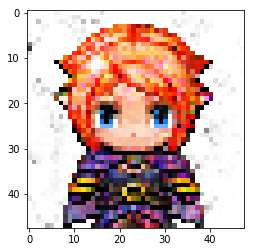

In [91]:
#@title autorun { run: "auto" }

param_number = 4 #@param {type:"integer", min:0, max:15}
param_value = 0.45 #@param {type:"slider", min:-1, max:1, step:0.01}

noise[0][param_number] = param_value
plt.imshow(predict_on_noise(cpu_est, noise))

[-1.         -0.19280974 -0.91013133  0.06456223  0.38386561 -0.10908201
  0.60728188 -0.81495852  0.5431961  -0.44782634 -0.16855228 -0.26803438
 -0.92172197  0.44793649  0.76643919 -0.3051638 ]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://tputestingmnist/DCGAN_6_small_latent_dim/model.ckpt-70000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:prediction_loop marked as finished
[-0.8        -0.19280974 -0.91013133  0.06456223  0.38386561 -0.10908201
  0.60728188 -0.81495852  0.5431961  -0.44782634 -0.16855228 -0.26803438
 -0.92172197  0.44793649  0.76643919 -0.3051638 ]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restorin

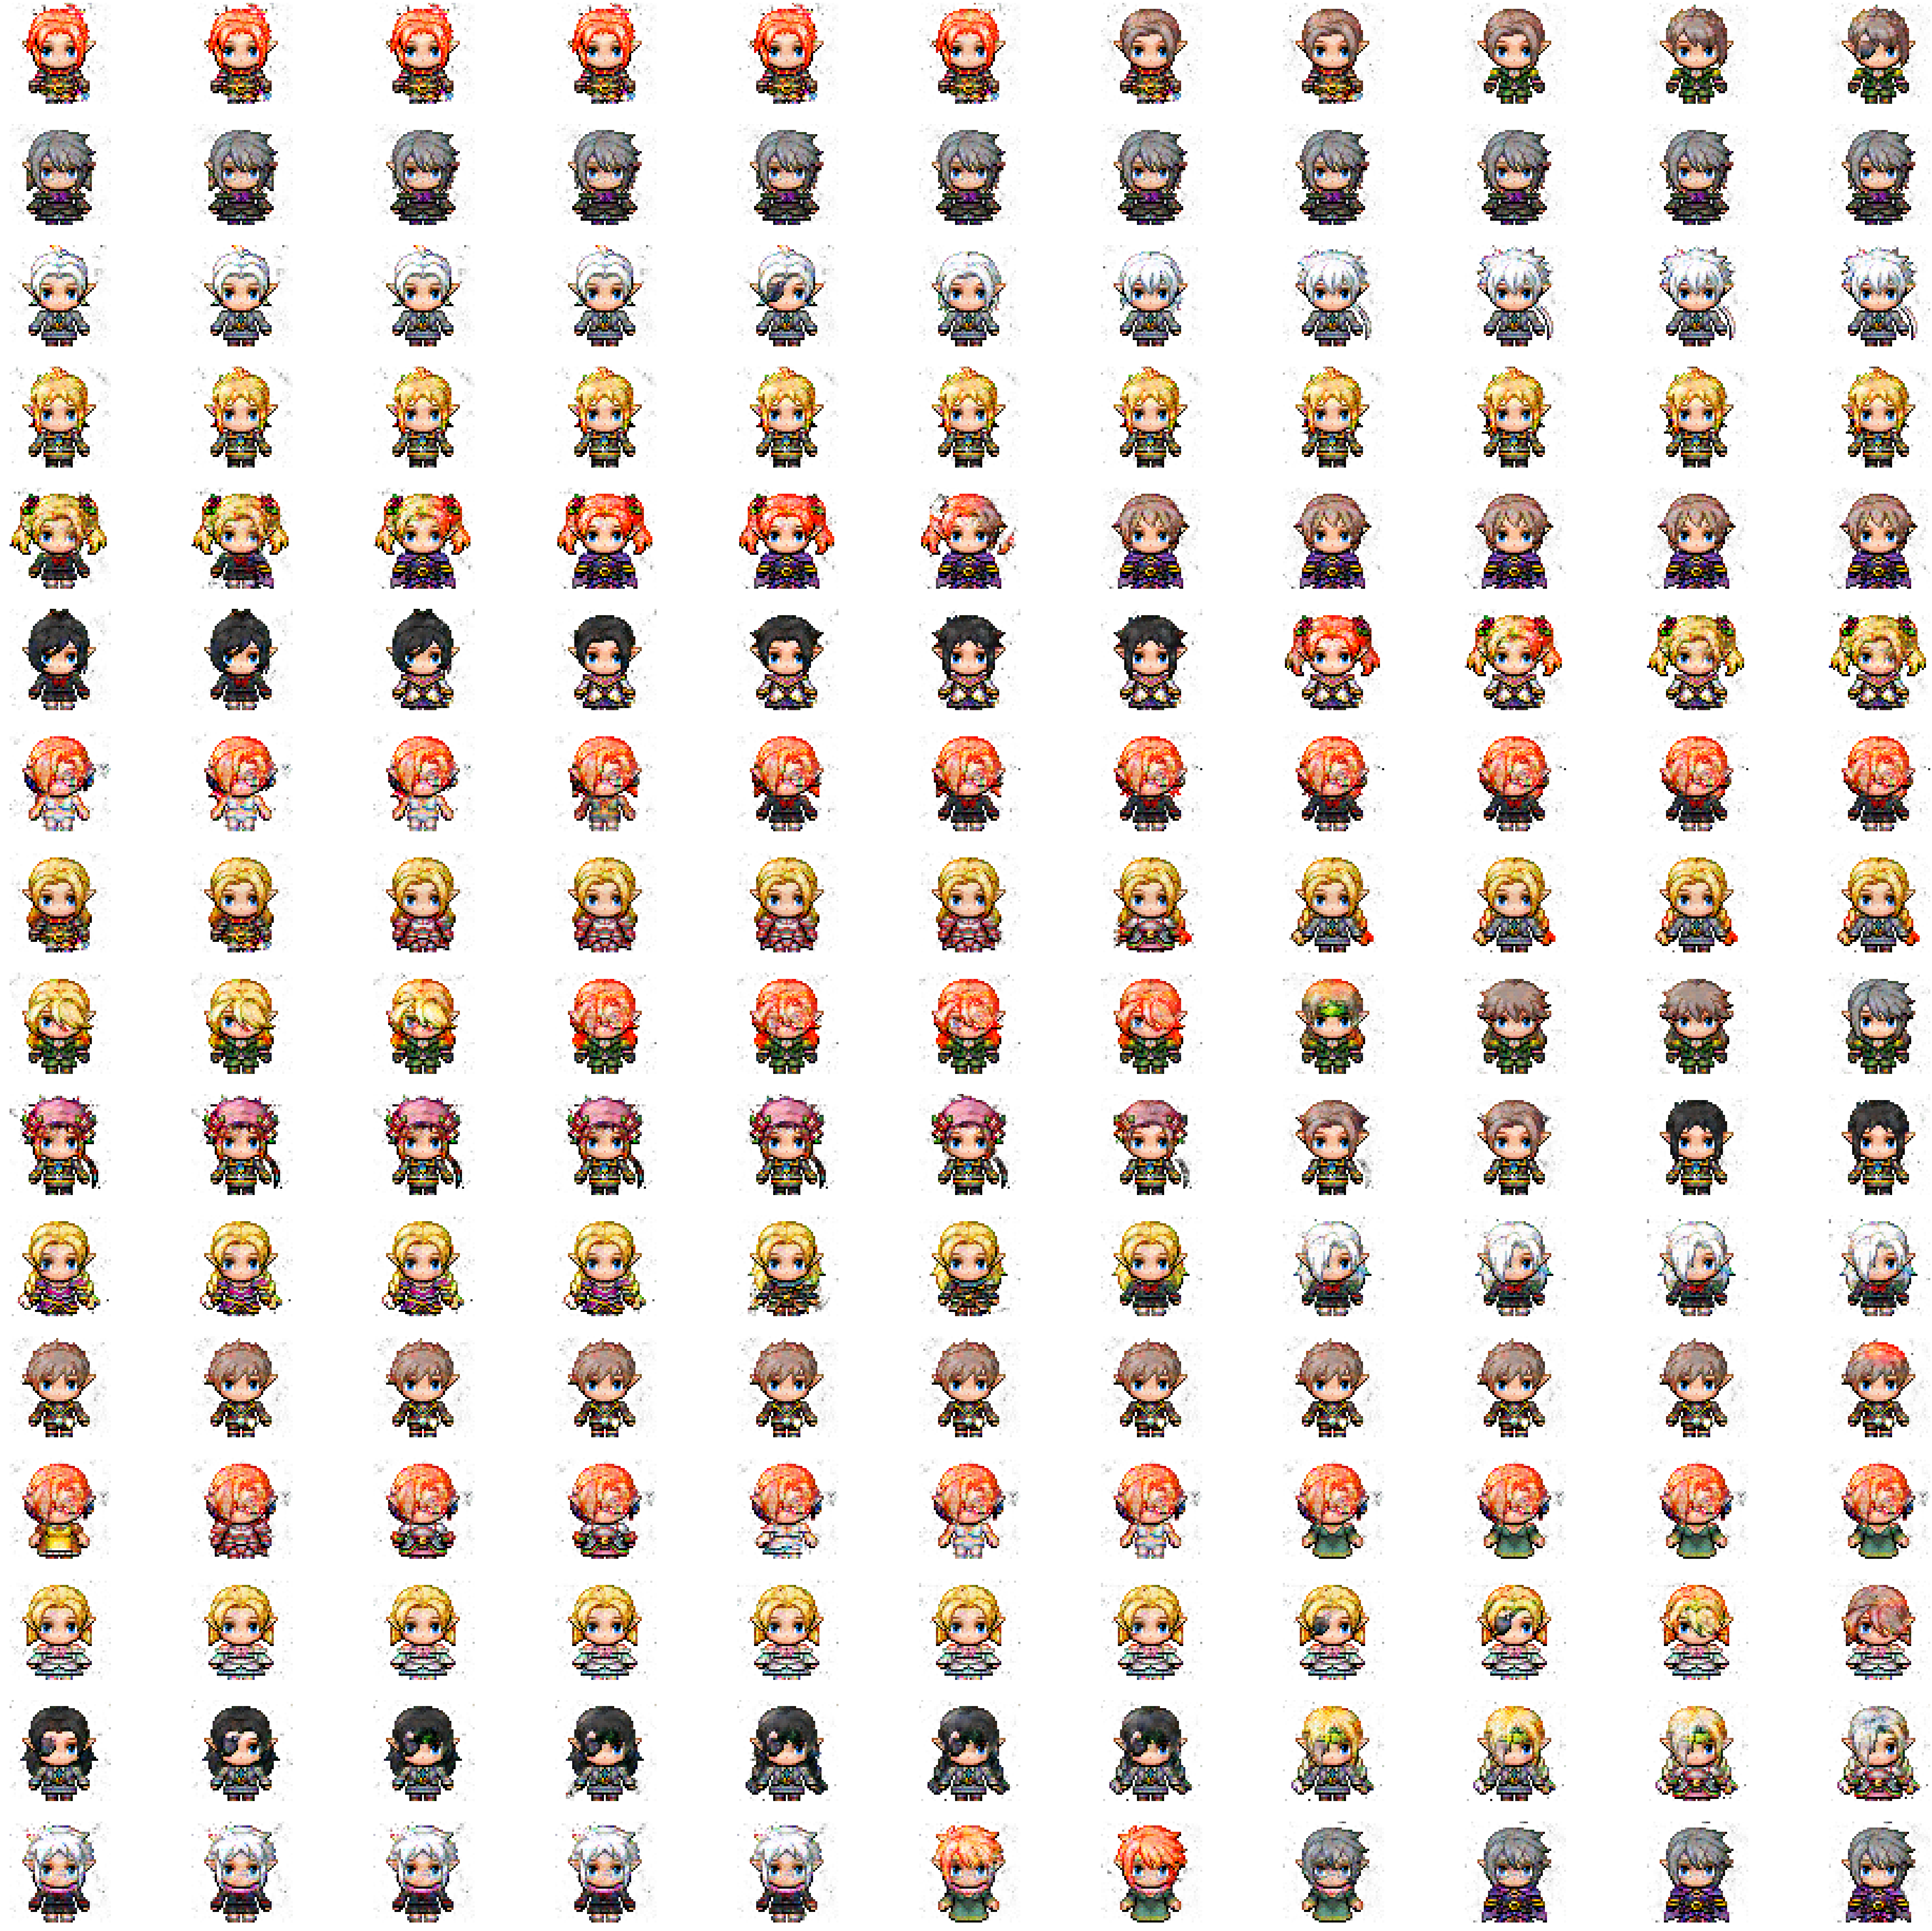

In [92]:
rows = 16
columns = 11

fig, axs = plt.subplots(rows, columns, figsize=(100,100))

for i in range(rows):
    noise = np.random.uniform(-1, 1, (BATCH_SIZE // 8, LATENT_DIM))
    for j in range(columns):
        
        noise[0][i] = -1 + 0.2 * j
        
        image = predict_on_noise(cpu_est, noise)
        axs[i,j].imshow(image)
        axs[i,j].axis('off')

fig.savefig(os.path.join(GOOGLE_DRIVE_DIR, 'feature_space.png'))
